In [1]:
import os
os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

import keras
import pandas as pd
import string
import re

Using plaidml.keras.backend backend.


In [2]:
os.getcwd()

'C:\\Users\\antra\\OneDrive\\kaggle\\sentiment_analysis\\keras'

In [3]:
os.listdir(os.getcwd())

['.ipynb_checkpoints',
 '.Rhistory',
 'imdb_binary_10000_words.csv',
 'imdb_binary_20000_words.csv',
 'imdb_binary_30000_words.csv',
 'imdb_binary_representation.ipynb',
 'imdb_keras.Rmd',
 'imdb_keras2.Rmd',
 'imdb_word_embedding_glove.ipynb',
 'labeledTrainData.tsv',
 'NN_processed_words_tf.csv',
 'NN_processed_words_tfidf.csv',
 'NN_processed_words_tfidf_10739words.csv',
 'NN_processed_words_tfidf_10739words_binarized.csv',
 'NN_processed_words_tfidf_4714words.csv',
 'NN_processed_words_tfidf_4714words_binarized.csv',
 'NN_processed_words_tfidf_6023words.csv',
 'NN_processed_words_tfidf_7164words.csv',
 'NN_processed_words_tf_4716words_binarized.csv',
 'NN_processed_words_tf_6023words.csv',
 'NN_processed_words_tf_6120words_binarized.csv',
 'NN_processed_words_tf_9792words_binarized.csv',
 'NN_unprocessed_words_tf.csv',
 'NN_unprocessed_words_tfidf.csv',
 'NN_unprocessed_words_tfidf_15343words.csv',
 'NN_unprocessed_words_tfidf_6120words.csv',
 'NN_unprocessed_words_tfidf_6120words_

In [4]:
# load file using relative path
train = pd.read_csv('labeledTrainData.tsv', sep='\t')
test = pd.read_csv('testData.tsv', sep='\t')

In [5]:
train

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...
...,...,...,...
24995,3453_3,0,It seems like more consideration has gone into...
24996,5064_1,0,I don't believe they made this film. Completel...
24997,10905_3,0,"Guy is a loser. Can't get girls, needs to buil..."
24998,10194_3,0,This 30 minute documentary Buñuel made in the ...


Let's do some **cleaning** in our texts: lower case; remove punctuations, remove numbers, replace abbreviations, etc. Because keras **tokenizer** does the punctuations removal; we don't have to manually do it.

In [6]:
# lowercase all words in text
def to_lower(docs):
    docs = [doc.lower() for doc in docs]
    return docs

In [7]:
# check for non-ascii character
def is_alpha(char):
    return char in string.ascii_lowercase

# only keep numbers and ascii characters. replace non-ascii characters with space
def keep_alphanumeric(doc):
    doc = [char for char in doc]
    out = ''
    for char in doc:
        good = is_alpha(char) or char.isnumeric() # or char in [' ', '.']
        if good:
            out += char
        else:
            out += ' '
    return out

In [8]:
# remove special characters
def remove_special(docs):
    docs = [keep_alphanumeric(doc) for doc in docs]
    return docs

In [9]:
# remove numbers
def remove_numbers(docs):
    docs = [re.sub('\d+', ' ', doc) for doc in docs]
    return docs

In [10]:
# removes extra whitespace for a list of text strings
def remove_whitespace(docs):
    docs = [' '.join(doc.split()) for doc in docs]
    docs = [doc.rstrip() for doc in docs]
    docs = [doc.lstrip() for doc in docs]
    return docs

In [11]:
train['review'] = to_lower(train['review'])

In [12]:
train['review'] = remove_special(train['review'])

In [13]:
train['review'] = remove_numbers(train['review'])

In [14]:
train['review'] = remove_whitespace(train['review'])

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

max_words = 10000 # considers only the top 10000 words for our sequences
maxlen = 500 # cut off review after 500 words (among the most common words in Tokenizer)

tokenizer = Tokenizer(num_words=max_words) # creates a tokenizer, takes only the first 10000 common words
tokenizer.fit_on_texts(train['review']) # build the word index
sequences = tokenizer.texts_to_sequences(train['review']) # turns strings into lists of integer indices of 10000 most common words

word_index = tokenizer.word_index # recover the all word indices that was computed
print('Found %s unique tokens.' % len(word_index)) # how many tokens are there in total?

Found 73276 unique tokens.


Let's decode the indices of one of the **sequences** back into original text.

In [16]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_review = ' '.join([reverse_word_index.get(i, '?') for i in sequences[0]])
decoded_review

'with all this stuff going down at the moment with mj i ve started listening to his music watching the odd documentary here and there watched the and watched again maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent is part biography part feature film which i remember going to see at the cinema when it was originally released some of it has subtle messages about mj s feeling towards the press and also the obvious message of drugs are bad m kay br br visually impressive but of course this is all about michael jackson so unless you remotely like mj in anyway then you are going to hate this and find it boring some may call mj an for to the making of this movie but mj and most of his fans would say that he made it for the fans which if true is really nice of him br br the actual feature film bit when it finally starts is only on for minutes or so the smooth criminal sequence an

Let's pad our word indices with 0's.

In [17]:
data = pad_sequences(sequences, maxlen=maxlen) # only take the last "max_len" words of the reviews, fill in the rest with 0's

print('Shape of data tensor:', data.shape)

Shape of data tensor: (25000, 500)


In [18]:
max([len(i) for i in sequences]) # number of words in the longest review

2235

In [19]:
len(data[0])

500

Create a binary representation of our word indices (1 for word presence; 0 for non-presence).

In [20]:
import numpy as np

def vectorize_sequences(sequences, dimension=max_words): # number of words in vocabulary (10000)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences): # create a counter starting from sequences 0
        results[i, sequence] = 1
    return results

x_train = vectorize_sequences(data) # vectorize training data for binary representation

In [21]:
x_train[0, 0:50]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.])

Now we are ready to train our network. First, let's create our **network architecture**.

In [22]:
from keras.models import Sequential # from keras.models import Sequential
from keras.layers import Dense # from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(max_words,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [23]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In order to evaluate how well our model performs on unseen data; we need to have a validation set. Let's use **20%** of our **training data** as **validation data**.

In [24]:
x_val = x_train[:5000]
partial_x_train = x_train[5000:]

y_val = train['sentiment'][:5000]
partial_y_train = train['sentiment'][5000:]

Now let's train the network for **20 epochs**.

In [25]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val))

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 7s 332us/step - loss: 0.4721 - acc: 0.8077 - val_loss: 0.3452 - val_acc: 0.8664
Epoch 2/20
20000/20000 [==============================] - 3s 128us/step - loss: 0.2739 - acc: 0.9043 - val_loss: 0.3091 - val_acc: 0.8738
Epoch 3/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.2102 - acc: 0.9266 - val_loss: 0.2750 - val_acc: 0.8874
Epoch 4/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.1710 - acc: 0.9413 - val_loss: 0.2770 - val_acc: 0.8910
Epoch 5/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.1467 - acc: 0.9478 - val_loss: 0.3063 - val_acc: 0.8806
Epoch 6/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.1233 - acc: 0.9585 - val_loss: 0.3098 - val_acc: 0.8842
Epoch 7/20
20000/20000 [==============================] - 3s 127us/step - loss: 0.1062 - acc: 0.9662 - val_loss: 0.3327 - v

Let's plot the **loss** on our **training** and **validation** set.

In [38]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1) # plus 1 because index in python only goes to len(loss) - 1

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

KeyError: 'val_loss'

Let's plot the **accuracy** on our training and validation set.

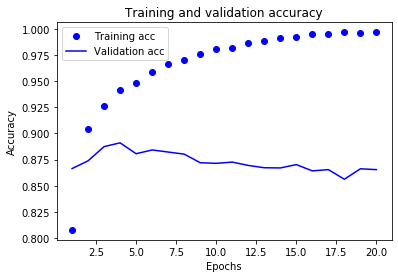

In [27]:
# plt.clf() # clears the figure

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Because the training accuracy starts decreasing after 7 epochs; let's re-train our model for 7 epochs using all data.

In [22]:
from keras.models import Sequential # from keras.models import Sequential
from keras.layers import Dense # from keras.layers import Dense

model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(max_words,)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"


In [23]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [28]:
history = model.fit(x_train,
                   train['sentiment'],
                   epochs=4,
                   batch_size=512)

Epoch 1/4
25000/25000 [==============================] - 4s 160us/step - loss: 0.1367 - acc: 0.9717
Epoch 2/4
25000/25000 [==============================] - 3s 104us/step - loss: 0.0791 - acc: 0.9805
Epoch 3/4
25000/25000 [==============================] - 3s 104us/step - loss: 0.0571 - acc: 0.9856
Epoch 4/4
25000/25000 [==============================] - 3s 103us/step - loss: 0.0428 - acc: 0.9895


Now that we have our finalized training model; let's use it to **predict** the **test set**. First, we are going to **clean up** the **test set** exactly like we did with the **training set**.

In [29]:
test = pd.read_csv('testData.tsv', sep='\t')

test['review'] = to_lower(test['review'])
test['review'] = remove_special(test['review'])
test['review'] = remove_numbers(test['review'])
test['review'] = remove_whitespace(test['review'])

Now that we have the texts in our test set cleaned up; let's **tokenize** the texts based on the **Tokenizer on training data**.

In [30]:
sequences_test = tokenizer.texts_to_sequences(test['review'])
test_data = pad_sequences(sequences_test, maxlen=maxlen) # truncate texts after "maxlen", or fill in with 0's if not long enough
x_test = vectorize_sequences(test_data) # vectorize test data for binary representation

In [31]:
predictions = model.predict(x_test) # these are probabilities that it belongs to positive class

In [32]:
sentiment = np.where(predictions >= 0.5, 1, np.where(predictions < 0.5, 0, predictions)) # if probabilities > 0.5; sentiment = 1

In [33]:
sentiment

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [1.],
       [1.]], dtype=float32)

In [34]:
test['sentiment'] = sentiment

In [35]:
del test['review']

In [36]:
test.to_csv('imdb_binary_10000_words.csv', index=False)